# Studies and testing

This notebook contains a summary of the development and a bunch of small tests run.


## Intro Code

The starting point in building a risk dashboard is to have some tools to simulate battles between players. First, som definitions. We define a battle as a sequence of combacts. Each combact is a roll of dice between an attacking and defending side. Each side can roll at most 3 dice. We have implemented this into the `Battle` and `Combact` classes, which are explained below.

In [5]:
import numpy as np

# local imports
from risk.combact import Combact
from risk.battle import Battle

## Combact simulator test

This is implemented into `risk.combact.Combact`. This class provides tools to simulate a combact between an attacking and defending side. Each side can roll anything between 1 and 3 dice. Once die have been rolled, they are sorted and, starting from the highest, compared against each others. For each pair, the attacking side wins if the die has a strictly higher number. 

This is implemented in the code below, where `n_attack` and `n_defend` are the number of units attacking and defending, respectively. Each roll of die is an extract between equally likely random rumbers. Once die have been roll on each side, we sort and compare them. This allows determin the amount of units destroyed by the attacking side `a_wins`. This is an array on lenght 4, where the `kk`-th element indicate the likelihood that the defence will lose kk units. Finally, note the the combact can be simulated `n_repeats` times, which will allow us to compute statistics (see below).

```python
def roll_and_sort(n_dice: int, n_repeats: int = 1) -> np.array:
    """..."""
    Outcomes = np.random.choice( (1, 2, 3, 4, 5, 6), (n_repeats, n_dice) )
    return np.sort(Outcomes)[:,::-1]


def simulate_combact( n_attack: int, n_defend: int, n_repeats: int = 1):
    """..."""

    # define comparison size
    n = min( n_attack, n_defend)
    
    # Simulate dice roll
    A = roll_and_sort( n_attack, n_repeats)[:,:n]
    D = roll_and_sort( n_defend, n_repeats)[:,:n]
    
    # Compare and count
    a_wins = (A>D).sum( axis=1)
    return a_wins
```

Chaining a bunch of combact one after the others will allow us to similate a battle. However, remeber that we are after statistics that can allow us to define better strategies. For e.g., if I am attacking with 10 units a territory defended by 4, what's the probability that I succed? How lukily am I to be left with at least x units - such that I do not lose the territory in the next round?

To achieve this we could use a Montecarlo approach, i.e. repeat a battle (sequence of combacts) several times and estimate the probabilities. This is, however, computationally inefficient, as it would require a lot of combacts to get converged statistics. A better solution is, lukily, possible.




A first step, is to derive *combact probabilities*. For e.g., if I am attacking with $n_a=3$ units, and my opponents defends with $n_d=2$, what's the probability $p(n_a, n_d, a)$ that I manage to destroy $a = 0, 1$ or $2$ of their units? This would already allow us to spee-up each combact simulation: given the units engaged in the fight ($n_a = \tilde{n_a}$ and $n_d = \tilde{n_d}$) instead of rolling dice, sorting and comparing, we'd just extract an outcome $a=[0, 1, 2, 3]$ from the probability distribution $p(n_a = \tilde{n_a}, n_d = \tilde{n_d}, a)$.

These probabilities could actually be combuted analytically, but the process can be a bit cumbersome and I am feeling lazy. Instead, I can just repeat a combact a few (million) of times and store the results into a 3D array  $\textbf{A}$ such that $ A_{i,j,k} = p(n_a=i, n_d=j, a=k)$. 

All methods to simulate a combact have been wrapped into the class `Combact`. Here, we built a method, `get_stats`, to compute the combact statistric ($\textbf{A}$). A (simplified) extract of the code is showed here:

```
n_run = 0
while n_run < n_repeats:
    n_run += batch_size

    for n_attack, n_defend in itertools.product( [1,2,3], [1,2,3]):
        _print(f"Simulating (attack vs defend): {n_attack} vs {n_defend}")

        # count attack wins
        a_wins = simulate_combact(n_attack, n_defend, batch_size)
        unique, _counts = np.unique(a_wins, return_counts=True)
        
        # count outcomes of attacking side winning 0, 1, 2, 3 units
        counts = np.zeros((4,), dtype=int)
        counts[unique] = _counts.astype(int)

        # store into matrices
        ii, jj = n_attack-1, n_defend-1
        self.A_wins_count[ii,jj,:] += counts

# compute probabilities and (half-size) confidence intervals
self.n_repeats += n_repeats
self.A_wins_prob = self.A_wins_count/self.n_repeats
self.A_wins_ci = 1.96*np.sqrt(  self.A_wins_prob*(1.-self.A_wins_prob) ) / np.sqrt(self.n_repeats)
```
As you can see, calculations can be done in batches, to avoid overloading the memory. We have embellished `Combact` with a few methods (`load_stats`, `dump_stats`) to store statistics and load them and even update them. This means that I can distribute the analysis over a few different times. But how many simulations should I run?

I tuned this by looking at the statics confidence intervals. Each probabilities is approximated as a Binomial distribution. Because none of the probabilities is close to zero, and as I can generate a lot of simulations quite cheaply, the normal approximation holds extremely well (e.g. compare vs `statsmodels.proportions.proportion_confint` using the 'Wilson' method, for example). The code comes with precomputed statistics from $4.5e^8$ simulations with 95% confidence inerval bounded to be below 0.001%. This is because the half confidence interval is, 
$$
h(z^*, p, n) = z^* \sqrt{ \frac{p (1-p)}{n} } <= h(z^*, p=0.5, n) = z^* \sqrt{\frac{0.5^2}{n}} = \frac{z^*}{2\sqrt{n}}
$$
which can be used to tune $n$.



Finally, I want to make sure that my number make sense. What can I test?

Well, aside from the obvious (sum of probabilities equal to 1), I can compare my probabilities to analytical ones for simple cases. Here, we derive probabilities for examples of increasing complexity:


### 1 vs 1 toss
Assume, $n_a=1$ and $n_d=1$. In this case, it's easily seen that
$$
p(a=0) = $\frac{(6^2+6)/2}{\cdot 6^2} = \frac{7}{12}
\quad \Rightarrow \quad
p(a=1) = 1-p(a=0)=\frac{5}{12}
$$

### 1 attack vs. any defense

Assume $n_a=1$ and any number of defensing sides. Being $A$ the outcome of the attack die, and $D_i$ the outcome of the i-th defense die (not sorted), we have:
$$
p(a=1) = 
\sum_{k=1}^6  p(A=k) p(D_1<k and D_2<k ...) =
\frac{1}{6} \sum_{k=1}^6 \frac{(k-1)^{n_d}}{6^{n_d}} = 
\frac{1}{6} \sum_{k=1}^6 \left( \frac{(k-1)}{6}\right)^{n_d}
$$
For $n_d$ imagine the &6 \times 6$ square of all $(D_1,D_2)$ dice permutations. The ones losing are the subsquare $(k-1)^2$. For $n_d=3$ you get a cube, but same concept.



### 1 defense vs any attack

p(a=0)


## 2 attack vs 1 defense toss

Assume $n_a=2$ and $n_d=1$. Call $A_i$ the outcome of attacking die for $i=1, 2$, and $D$ the vaue of the defence die. We get that:
$$
p(a=1) = 
P(A1>D or A2>D) = 
\sum_{k=1}^6 P(D=k) P(A_1>k or A_2>k) = 
\sum_{k=1}^6 \frac{1}{6} not[ P(A_1 \le k \& A_2 \le k)] = 
\frac{1}{6} \sum_{k=1}^6 \left( 1-\frac{k^2}{6^2} \right)
$$ 
For the last bit, I imagine a $6 \times 6$ square, of all the possible combinations $A_1, A_2$. The ones which do not win, are those such that $A_{1,2}\le k$, i.e. a square of side $k$. 




In a similar way, if $n_a=1$ and $n_d=2$:
$$
p(a=1) = 
\sum_k p(A=k) p(D_1<k \& D_2<k) = 
\frac{1}{6} \sum_k \frac{(k-1)^2}{6^2} = 
\frac{1}{6^3} \sum_{k=1}^6 (k-1)^2
$$


These checks have been implemented in tests: we know to what reference values our proportions converge. We also know that the uncertainty decreases with the square root of the number of simulations, $n$. So we should expect the same convergence speed.

In [57]:
C = Combact()
n_reps = np.array([10**ii for ii in range(1,6)], dtype=int)

# 1 vs 1
n_a, n_d = 1, 1
p_ref = 5./12.
err_1_vs_1 = np.zeros_like(n_reps).astype(float)
for ii,nn in enumerate(n_reps):
    p_num = C.simulate( n_a, n_d, nn, use_stats=False).sum()/nn
    err_1_vs_1[ii] = abs(p_num-p_ref)


# 2 vs 1
n_a, n_d = 2, 1
p_ref = (1. - 7./6. * 13./36.)
err_2_vs_1 = np.zeros_like(n_reps).astype(float)
for ii,nn in enumerate(n_reps):
    p_num = C.simulate( n_a, n_d, nn, use_stats=False).sum()/nn
    err_2_vs_1[ii] = abs(p_num-p_ref)

print()

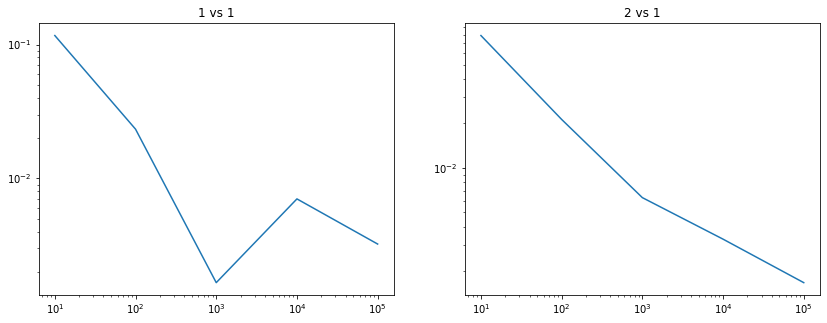

In [59]:
import matplotlib.pyplot as plt
fig = plt.figure('Convergence plots', (14,5))
Ax = fig.subplots(1,2,squeeze=False)
ax = Ax[0,0]
ax.loglog( n_reps, err_1_vs_1, lw=4)
ax.set_title(r'1 vs 1')

ax = Ax[0,1]
ax.loglog( n_reps, err_2_vs_1, lw=4)
ax.set_title(r'2 vs 1')
plt.show()


In both cases, the number of simulations is up by 4 orders of magnitude, while the error goes down of 2. The convergence is with the root of $n$, as expected.